# **Final Project Hacktiv8 Group 4 | Product Input Automation**

**Gde Ondy Janeswara**

**Pramudya Adi Nugraha**

**Julio Putra David**

**Muhammad Farhan Zahirsyah**

### Description

Melakukan Input produk baru didalam suatu Ecommerce biasanya akan memakan waktu yang lama, apalagi produk yang dimasukan tidaklah sedikit. Model dibuat untuk mempermudah seorang Administrator Ecommerce dalam kegiatan memasukan informasi produk. Dengan adanya model ini, Admin hanya perlu mengunggah 1 buah gambar produk kemudian model akan melakukan prediksi untuk ke setiap informasi produk yang harus dimasukan sesuai dengan gambar tersebut. Diharapkan menggunakan model ini dapat mempersingkat waktu seorang Admin Ecommerce melakukan Input produk juga bisa mengurangi beban kerja untuk input produk baru.

### Problem 
- Input produk baru didalam suatu Ecommerce membutuhkan waktu yang lama.

### Objective
- mempersingkat waktu seorang Admin Ecommerce melakukan Input produk. 
- mengurangi beban kerja untuk input produk baru.

---


In [30]:
import difflib, keras, nltk, pickle, re, requests, string, warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from io import BytesIO
from PIL import Image, ImageOps
from tqdm import tqdm
from feature_engine.outliers import OutlierTrimmer, Winsorizer
from feature_engine.imputation import DropMissingData
from keras.layers import BatchNormalization, Dense, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing import image
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
warnings.filterwarnings('ignore')

## **1. Multi Label Classification**

loading data

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/summer-products-with-rating-and-performance_2020-08.csv')

copy data dari data original

In [8]:
data = df.copy()

melakukan cleaning data tag dan juga mengurangi jumlah tagging

In [9]:
whitelist = ['casual', 'plus size', 'sleeveless', 'dress', 'shorts', 'tops', 'sexy', 'beach', 'sleeve', 'short sleeves', 'print', 'shirt', 'tank', 'necks', 'v-neck', 'printed', 't shirts', 'tank top', 'cotton', 'summer dress', 'ladies', 'loose', 'blouse', 'pants', 'vest', 'beach dress', 'women dress', 'floral', 'lace', 'mini dress', 'mini', 'slim', 'sleeveless dress', 'round neck', 'casual dress', 'waist', 'party', 'long dress', 'party dress', 'sport', 'floral print', 'slim fit', 'backless', 'jumpsuit', 'short pants', 'bikini', 'swimsuit']

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('summer', '', text)
    text = re.sub("women's fashion", '', text)
    text = re.sub('fashion', '', text)
    text = re.sub('printed', '', text)
    text = re.sub('women fashion', '', text)
    text = re.sub('spaghetti', '', text)
    text = re.sub('sleeve', 'sleeveless', text)
    text = re.sub('short sleeves', 'sleeveless', text)
    text = re.sub('sleeveless dress', 'sleeveless', text)
    text = re.sub('summer dress', 'dress', text)
    text = re.sub('beach dress', 'dress', text)
    text = re.sub('casual dress', 'dress', text)
    text = re.sub('women dress', 'dress', text)
    text = re.sub('mini dress', 'dress', text)
    text = re.sub('mini', 'dress', text)
    text = re.sub('long dress', 'dress', text)
    text = re.sub('backless', 'dress', text)
    text = re.sub('shorts', 'shorts', text)
    text = re.sub('short pants', 'shorts', text)
    text = re.sub('tops', 'tank top', text)
    text = re.sub('tank', 'tank top', text)
    text = re.sub('t shirts', 'shirt', text)
    text = re.sub('printed', 'print', text)
    text = re.sub('floral', 'print', text)
    text = re.sub('floral print', 'print', text)
    text = re.sub('necks', 'v-neck', text)
    text = re.sub('round neck', 'v-neck', text)
    text = re.sub('short pants', 'pants', text)
    text = re.sub('slim fit', 'slim', text)
    text = re.sub('party dress', 'party', text)
    text = re.sub('swimsuit', 'sport', text)
    return text

dilakukan cleaning

In [10]:
data['tags'] = data['tags'].apply(lambda x:clean_text(x))

splitting data berdasarkan koma

In [11]:
for i in range(len(data)):
    data['tags'][i] = data['tags'][i].split(',')

mengambil tiap data untuk dijadikan list

In [12]:
b = []
for x in range(len(data)):
    a = []
    for i in range(len(whitelist)):
        if whitelist[i] in data['tags'][x]:
            a.append(whitelist[i])
    b.append(a)    

pada baris tag terdapat beberapa tag yang mencerminkan dari produk tersebut

In [13]:
data['tags'] = b
data['tags']

0                          [casual, shorts, print, shirt]
1                            [casual, dress, sexy, party]
2                                          [beach, sport]
3             [sleeveless, shorts, shirt, v-neck, cotton]
4         [casual, plus size, shorts, loose, pants, lace]
                              ...                        
1568    [casual, plus size, sleeveless, shorts, print,...
1569                            [plus size, shorts, lace]
1570                                      [shorts, sport]
1571                 [dress, beach, v-neck, ladies, lace]
1572                                 [pants, slim, sport]
Name: tags, Length: 1573, dtype: object

dilakukan multi label binarizer untuk dilakukan one hot pada multi label kolom tag

In [14]:
binarizer = MultiLabelBinarizer()
binary_fit = binarizer.fit(data['tags'])
binary_transform = binarizer.transform(data['tags'])
df_binary = pd.DataFrame(binary_transform, columns=binarizer.classes_)

melihat hasil dari multi label binarizer

In [ ]:
df_binary

,beach,bikini,blouse,casual,cotton,dress,jumpsuit,lace,ladies,loose,...,shirt,shorts,sleeveless,slim,sport,tank top,v-neck,vest,waist,women dress
0,0,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,1,1,1,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,0,0,0,1,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
1569,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1570,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1571,1,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0


loading data image yang telah di download pada folder lokal

In [15]:
path = []
for i in range(len(df)):
    path.append(f"/content/drive/MyDrive/Colab Notebooks/picture/{i}.jpg")

data['product_path'] = path

mengkombinasikan data tag dan path gambar

In [16]:
data1 = data[['tags','product_path']]

In [17]:
data1

,tags,product_path
0,"[casual, shorts, print, shirt]",/content/drive/MyDrive/Colab Notebooks/picture...
1,"[casual, dress, sexy, party]",/content/drive/MyDrive/Colab Notebooks/picture...
2,"[beach, sport]",/content/drive/MyDrive/Colab Notebooks/picture...
3,"[sleeveless, shorts, shirt, v-neck, cotton]",/content/drive/MyDrive/Colab Notebooks/picture...
4,"[casual, plus size, shorts, loose, pants, lace]",/content/drive/MyDrive/Colab Notebooks/picture...
...,...,...
1568,"[casual, plus size, sleeveless, shorts, print,...",/content/drive/MyDrive/Colab Notebooks/picture...
1569,"[plus size, shorts, lace]",/content/drive/MyDrive/Colab Notebooks/picture...
1570,"[shorts, sport]",/content/drive/MyDrive/Colab Notebooks/picture...
1571,"[dress, beach, v-neck, ladies, lace]",/content/drive/MyDrive/Colab Notebooks/picture...


menggabungkan path image dengan label yang telah dilakukan multi label binarizer

In [18]:
train = pd.concat([data1, df_binary], axis=1)
train

,tags,product_path,beach,bikini,blouse,casual,cotton,dress,jumpsuit,lace,...,shirt,shorts,sleeveless,slim,sport,tank top,v-neck,vest,waist,women dress
0,"[casual, shorts, print, shirt]",/content/drive/MyDrive/Colab Notebooks/picture...,0,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,"[casual, dress, sexy, party]",/content/drive/MyDrive/Colab Notebooks/picture...,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[beach, sport]",/content/drive/MyDrive/Colab Notebooks/picture...,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,"[sleeveless, shorts, shirt, v-neck, cotton]",/content/drive/MyDrive/Colab Notebooks/picture...,0,0,0,0,1,0,0,0,...,1,1,1,0,0,0,1,0,0,0
4,"[casual, plus size, shorts, loose, pants, lace]",/content/drive/MyDrive/Colab Notebooks/picture...,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,"[casual, plus size, sleeveless, shorts, print,...",/content/drive/MyDrive/Colab Notebooks/picture...,0,0,0,1,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
1569,"[plus size, shorts, lace]",/content/drive/MyDrive/Colab Notebooks/picture...,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1570,"[shorts, sport]",/content/drive/MyDrive/Colab Notebooks/picture...,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1571,"[dress, beach, v-neck, ladies, lace]",/content/drive/MyDrive/Colab Notebooks/picture...,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0


melakukan perubahan dari image menjadi array

In [19]:
train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img(f"/content/drive/MyDrive/Colab Notebooks/picture/{i}.jpg",target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 1573/1573 [13:46<00:00,  1.90it/s]


drop kolom yang tidak digunakan untuk target label y

In [20]:
y = np.array(train.drop(['tags', 'product_path'],axis=1))

spliting data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [22]:
xytrain = tf.data.Dataset.from_tensor_slices((X_train, y_train))
xytrain = xytrain.shuffle(buffer_size=1024).batch(64)
xytest = tf.data.Dataset.from_tensor_slices((X_test, y_test))
xytest = xytest.batch(64)

membuat model dengan menggunakan pretrained model ResNet50V2

In [23]:
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=(224,224,3), include_top=False, classes=1000)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()

model.add(base_model)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2, padding ='same'))

model.add(Flatten())
model.add(Dense(250, activation = 'relu'))
model.add(Dense(125, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))

model.add(Dense(25, activation='sigmoid'))

94683136/94668760 [==============================] - 1s 0us/step


summary dari arsitektur model

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 2048)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 250)               8192250   
                                                                 
 dense_1 (Dense)             (None, 125)               3

compile model

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

melakukan fitting dan training model

In [26]:
model_history = model.fit(xytrain, epochs=10, validation_data=(xytest), batch_size=64)

Epoch 1/10
23/23 [==============================] - 223s 10s/step - loss: 0.4820 - accuracy: 0.1887 - val_loss: 0.3535 - val_accuracy: 0.2975
Epoch 2/10
23/23 [==============================] - 219s 10s/step - loss: 0.2854 - accuracy: 0.2954 - val_loss: 0.3052 - val_accuracy: 0.2848
Epoch 3/10
23/23 [==============================] - 214s 9s/step - loss: 0.1980 - accuracy: 0.3166 - val_loss: 0.2877 - val_accuracy: 0.2595
Epoch 4/10
23/23 [==============================] - 217s 9s/step - loss: 0.1501 - accuracy: 0.3088 - val_loss: 0.2749 - val_accuracy: 0.2911
Epoch 5/10
23/23 [==============================] - 252s 11s/step - loss: 0.1216 - accuracy: 0.3124 - val_loss: 0.2787 - val_accuracy: 0.2215
Epoch 6/10
23/23 [==============================] - 216s 9s/step - loss: 0.1154 - accuracy: 0.2989 - val_loss: 0.2843 - val_accuracy: 0.2848
Epoch 7/10
23/23 [==============================] - 215s 9s/step - loss: 0.0960 - accuracy: 0.3011 - val_loss: 0.2903 - val_accuracy: 0.2848
Epoch 8/10

In [27]:
model_metric = pd.DataFrame (model_history.history)

evaluasi model

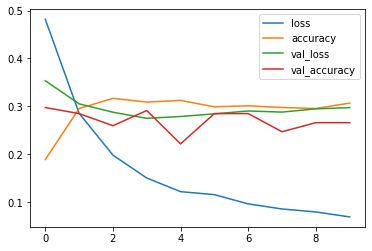

In [28]:
model_metric.plot()

classification report

In [31]:
y_pred_model = model.predict(xytest)
y_pred_model = np.where(y_pred_model >= 0.5, 1, 0)
print(classification_report(y_test, y_pred_model))

              precision    recall  f1-score   support

           0       0.79      0.61      0.69        31
           1       0.73      0.80      0.76        10
           2       0.91      0.56      0.69        18
           3       0.78      0.88      0.83        86
           4       0.57      0.53      0.55        15
           5       0.88      0.92      0.90        62
           6       1.00      0.60      0.75        10
           7       0.91      0.59      0.71        17
           8       0.64      0.37      0.47        19
           9       0.80      0.57      0.67        21
          10       0.75      0.83      0.79        18
          11       0.81      0.65      0.72        20
          12       0.82      0.75      0.78        72
          13       0.78      0.80      0.79        35
          14       0.59      0.59      0.59        37
          15       0.62      0.60      0.61        30
          16       0.78      0.88      0.83        51
          17       0.65    

R2 score

In [32]:
r2_score(y_test, y_pred_model)

0.33829818437452275

save model

In [33]:
model.save('model', save_format = 'tf')

INFO:tensorflow:Assets written to: model/assets


mendownload model menjadi zip

In [34]:
!zip -r /content/Model.zip /content/model

from google.colab import files
files.download('/content/Model.zip')

  adding: content/model/ (stored 0%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/model/variables/variables.index (deflated 76%)
  adding: content/model/keras_metadata.pb (deflated 96%)
  adding: content/model/saved_model.pb (deflated 92%)
  adding: content/model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

melakukan percobaan kepada data inference

sport (0.952)
pants (0.875)
slim (0.523)


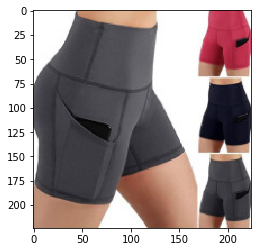

In [ ]:
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/picture/1572.jpg',target_size=(224,224,3))
img = image.img_to_array(img)
img = img/255
classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

mengambil image dari internet dan melihat performanya

shirt (0.987)
shorts (0.964)
sleeveless (0.849)


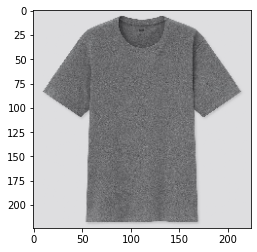

In [ ]:
img = image.load_img('/content/drive/MyDrive/goods_08_441598.jpg',target_size=(224,224,3))
img = image.img_to_array(img)
img = img/255
classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

dress (0.902)
sexy (0.462)
casual (0.188)


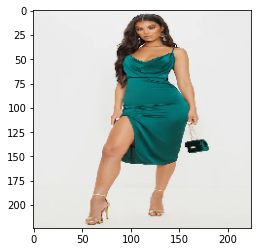

In [ ]:
img = image.load_img('/content/drive/MyDrive/test.jpg',target_size=(224,224,3))
img = image.img_to_array(img)
img = img/255
classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

shorts (0.946)
shirt (0.885)
sleeveless (0.497)


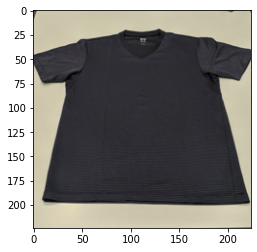

In [ ]:
response = requests.get(str('https://images.tokopedia.net/img/cache/500-square/VqbcmM/2020/10/20/3df0fd16-cb55-4b81-aed4-c94877300ce6.jpg'))
img = Image.open(BytesIO(response.content))
img = ImageOps.fit(img, (224,224))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

## **2. Recommender System**

Recomender system ini digunakan sebagai input dari data yang pernah dimasukan. cara kerjanya adalah mencari similarity tag dari yang telah diprediksi oleh model multilabel ke dataset yang ada. kemudian mencari nilai similarity yang paling dekat. dari situ menjadi auto fill dari informasi produk yang telah di input dari gambarnya

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/recomender_data.csv')

cleaning dataset

In [ ]:
df2.drop(['Unnamed: 0'], axis=1, inplace=True)
df2['tags']  = df2['tags'].str.strip('[]')
df2

,tags
0,"'casual', 'shorts', 'print', 'shirt'"
1,"'casual', 'dress', 'sexy', 'party'"
2,"'beach', 'sport'"
3,"'sleeveless', 'shorts', 'shirt', 'v-neck', 'co..."
4,"'casual', 'plus size', 'shorts', 'loose', 'pan..."
...,...
1568,"'casual', 'plus size', 'sleeveless', 'shorts',..."
1569,"'plus size', 'shorts', 'lace'"
1570,"'shorts', 'sport'"
1571,"'dress', 'beach', 'v-neck', 'ladies', 'lace'"


dilakukan tokenizer untuk ke setiap kolomnya, kemudian menghitung skor similarity dari nilai tagnya dengan semua tag yang ada didalam dataset. kemudian dimasukan kedalam dataframe dan disort berdasarkan similaritynya. kemudian mengambil nilai teratas

In [ ]:
sentence = []
for i in range(len(df2)):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    new_words = tokenizer.tokenize(df2['tags'][i])
    sentence.append(new_words)
df2['tags'] = sentence

predict = ['party','dress','sexy'] # ini yang jadi input dari model multi label classification
similarity= []
for i in range(len(df2)):
    seq = difflib.SequenceMatcher(None,predict,df2['tags'][i])
    d = seq.ratio()*100
    similarity.append(d)
df2['similarity'] = similarity
df2['index'] = df2.index.copy()

df_result = df2.sort_values(by=['similarity'], ascending=False).head(1)
df_result

,tags,similarity,index
184,"[dress, sexy]",80.0,184


nilai similarity terbesar ada di 80 dengan index 184, index 184 ini menjadi recommendation untuk fill in the blank form informasi prediction

In [ ]:
feature_result = df.iloc[df_result['index']]
feature_result

,title,title_orig,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,...,merchant_rating_count,merchant_rating,merchant_id,merchant_has_profile_picture,merchant_profile_picture,product_url,product_picture,product_id,theme,crawl_month
184,2018 Summer New Women Jupes Longues Jupes Soli...,2018 Summer New Women Long Skirts Solid Sexy S...,9.0,36,EUR,20000,0,4.09,4345,2341.0,...,49327,4.168346,595b54fcd44a9b1180cb102b,0,NaN,https://www.wish.com/c/59cc60cb86ac5b2f32a92b8a,https://contestimg.wish.com/api/webimage/59cc6...,59cc60cb86ac5b2f32a92b8a,summer,2020-08


## **3. Price Prediction**

melakukan drop feature

In [ ]:
data.drop(['has_urgency_banner', 'urgency_text', 'merchant_profile_picture'], axis=1, inplace=True)

mengubah nilai price menjadi rupiah dari euro

In [ ]:
# exchange rate on June 4, 2022
data['price'] = 15471 * data['price']
data['retail_price'] = 15471 * data['retail_price']

membuat data inference

In [ ]:
data_inf = data.sample(10, random_state=77)
data.drop(data_inf.index, inplace=True)
data.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

melakukan splitting dataset

In [ ]:
X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)
print('Size of feature training data :', X_train.shape)
print('Size of feature testing data  :', X_test.shape)
print('Size of target training data :', y_train.shape)
print('Size of target testing data  :', y_test.shape)

Size of feature training data : (1250, 39)
Size of feature testing data  : (313, 39)
Size of target training data : (1250,)
Size of target testing data  : (313,)


membuat kolom yang harus di trimming dan capping

In [ ]:
otl_trim = ['rating', 'merchant_rating']
otl_cap = ['units_sold', 'rating_count', 'rating_five_count', 'rating_four_count', 
           'rating_three_count', 'rating_two_count', 'rating_one_count', 'countries_shipped_to', 'merchant_rating_count']

melakukan capping dengan winsorizer

In [ ]:
winsorizer = Winsorizer(capping_method='iqr', 
                        tail='both',
                        fold=1.5,
                        variables=otl_cap,
                        missing_values='ignore')

X_train_capped = winsorizer.fit_transform(X_train)

melakukan trimming dengan outlier trimmer

In [ ]:
outlier_trimmer = OutlierTrimmer(capping_method='iqr', 
                                 tail='both', 
                                 fold=1.5, 
                                 variables=otl_trim, 
                                 missing_values='ignore')

X_train_trimmed = outlier_trimmer.fit_transform(X_train_capped)
print('Size dataset - Before trimming : ', X_train_capped.shape)
print('Size dataset - After trimming  : ', X_train_trimmed.shape)

Size dataset - Before trimming :  (1250, 39)
Size dataset - After trimming  :  (1154, 39)


drop missing value

In [ ]:
X_train_clean = X_train_trimmed.dropna(how='any', axis=0)
X_test_clean = X_test.dropna(how='any', axis=0)

memisah feature target dari dataset

In [ ]:
y_train_new = y_train[X_train_clean.index]
y_test_new = y_test[X_test_clean.index]

melihat korelasi antar feature untuk diseleksi 

In [ ]:
data_select = X_train_clean.copy()
data_select['price'] = y_train_new
data_select.corr()

,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,...,badge_fast_shipping,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,merchant_rating_count,merchant_rating,merchant_has_profile_picture,price
retail_price,1.000000,0.002662,-0.027282,0.054685,0.049530,0.055373,0.053840,0.037386,0.024444,0.016079,...,-0.006769,0.112692,0.245146,0.001312,0.124132,-0.017556,0.074379,0.101764,0.020763,0.279505
units_sold,0.002662,1.000000,-0.030895,0.123701,0.930712,0.919824,0.921194,0.925345,0.906199,0.882283,...,-0.074261,0.199012,0.002418,-0.032366,-0.005732,0.048877,0.331401,0.151644,0.109729,0.000662
uses_ad_boosts,-0.027282,-0.030895,1.000000,-0.023409,-0.057744,-0.054019,-0.050670,-0.060917,-0.077032,-0.075435,...,0.023343,-0.150996,-0.075893,-0.037186,-0.015610,0.034001,0.024197,-0.003773,-0.001077,-0.083072
rating,0.054685,0.123701,-0.023409,1.000000,0.153954,0.227607,0.176830,0.093472,0.014511,-0.051665,...,-0.007274,0.102981,0.114319,-0.008206,0.063034,-0.044985,0.108863,0.257285,0.049957,0.117516
rating_count,0.049530,0.930712,-0.057744,0.153954,1.000000,0.989243,0.994665,0.989102,0.960771,0.929130,...,-0.072367,0.207321,0.047965,-0.034320,0.004806,0.050579,0.354358,0.187609,0.110990,0.047396
rating_five_count,0.055373,0.919824,-0.054019,0.227607,0.989243,1.000000,0.988542,0.962502,0.918929,0.877938,...,-0.072894,0.213569,0.054338,-0.034070,0.012266,0.050231,0.361543,0.213109,0.116486,0.053727
rating_four_count,0.053840,0.921194,-0.050670,0.176830,0.994665,0.988542,1.000000,0.982436,0.945990,0.907313,...,-0.070008,0.212057,0.050873,-0.033934,0.014012,0.049420,0.359694,0.197558,0.111743,0.051927
rating_three_count,0.037386,0.925345,-0.060917,0.093472,0.989102,0.962502,0.982436,1.000000,0.979966,0.953782,...,-0.072010,0.203349,0.034980,-0.034409,0.006954,0.050466,0.346581,0.162988,0.101391,0.033156
rating_two_count,0.024444,0.906199,-0.077032,0.014511,0.960771,0.918929,0.945990,0.979966,1.000000,0.980863,...,-0.068266,0.185787,0.016642,-0.033337,-0.008717,0.049273,0.329957,0.130454,0.094167,0.018020
rating_one_count,0.016079,0.882283,-0.075435,-0.051665,0.929130,0.877938,0.907313,0.953782,0.980863,1.000000,...,-0.069314,0.172488,0.032341,-0.033316,-0.022003,0.050207,0.310550,0.108358,0.098069,0.030759


melakukan seleksi feature yang akan digunakan ke dalam model

In [ ]:
X_train_select = X_train_clean[['retail_price','product_variation_inventory','shipping_option_name',
                              'shipping_option_price','shipping_is_express', 
                              'inventory_total']]

X_test_select = X_test_clean[['retail_price','product_variation_inventory','shipping_option_name',
                              'shipping_option_price','shipping_is_express',
                              'inventory_total']]

membagi kolom feature numerik dan categorical untuk dilakukan encoding dan scaling

In [ ]:
num_columns  = ['retail_price','product_variation_inventory','inventory_total']
cat_columns  = ['shipping_option_name']
no_treat = ['shipping_option_price', 'shipping_is_express']

X_train_num = X_train_select[num_columns]
X_train_cat = X_train_select[cat_columns]
X_train_not = X_train_select[no_treat]

X_test_num = X_test_select[num_columns]
X_test_cat = X_test_select[cat_columns]
X_test_not = X_test_select[no_treat]

dilakukan standard scaling kepada feature numerikal

In [ ]:
# Scaling
standard_scaler = StandardScaler()
standard_scaler.fit(X_train_num)

X_train_num_scaled_standard = standard_scaler.transform(X_train_num)
X_test_num_scaled_standard = standard_scaler.transform(X_test_num)
print(X_train_num_scaled_standard.shape)
print(X_test_num_scaled_standard.shape)

(1096, 3)
(286, 3)


dilakukan one hot encoder kepada feature kategorikal

In [ ]:
# Encoding
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_cat_enc = encoder.fit_transform(X_train_cat).toarray()
X_test_cat_enc = encoder.transform(X_test_cat).toarray()
print(X_train_cat_enc.shape)
print(X_test_cat_enc.shape)

(1096, 14)
(286, 14)


menggabungkan feature yang telah di encode dan scaling

In [ ]:
# Concat scaled and encoded data
X_train_final = np.concatenate([X_train_num_scaled_standard, X_train_cat_enc, X_train_not], axis = 1)
X_test_final = np.concatenate([X_test_num_scaled_standard, X_test_cat_enc, X_test_not], axis = 1)
print(X_train_final.shape)
print(X_test_final.shape)

(1096, 19)
(286, 19)


membuat model gradient boosting regressor

In [ ]:
gbreg = GradientBoostingRegressor(random_state=77)

fitting model

In [ ]:
gbreg.fit(X_train_final, y_train_new)

GradientBoostingRegressor(random_state=77)

evaluasi model

In [ ]:
y_pred_test_gb = gbreg.predict(X_test_final)

print('r2:', r2_score(y_test_new, y_pred_test_gb))
print('MAE:', mean_absolute_error(y_test_new, y_pred_test_gb))
print('MSE', mean_squared_error(y_test_new, y_pred_test_gb))
print('='*50)
print('Train score:', gbreg.score(X_train_final, y_train_new))
print('Test score:', gbreg.score(X_test_final, y_test_new))

r2: 0.8693842938417312
MAE: 15106.277271045343
MSE 415471280.0971129
Train score: 0.8986108675218354
Test score: 0.8693842938417312


didapatkan r2 dengan nilai 89% pada train data dan 86% di test data

melakukan hyperparameter tuning dengan mengubah parameter di gradient boosting regressor

In [ ]:
param_grid_gbreg = [{'criterion' : ['friedman_mse', 'squared_error', 'mse'],
                     'learning_rate' : [float(x) for x in np.linspace(0, 1, num = 5)],
                     'n_estimators' : [int(x) for x in np.linspace(75, 200, num = 5)],
                     'min_samples_leaf' : [float(x) for x in np.linspace(0, 1, num = 5)],
                     'min_weight_fraction_leaf' : [float(x) for x in np.linspace(0, 1, num = 5)],
                     'max_depth' : [int(x) for x in np.linspace(1, 10, num = 5)],
                     'min_impurity_decrease' : [float(x) for x in np.linspace(0, 1, num = 5)]
                   }]

membuat pipeline

In [ ]:
# Numerical pipeline
num_pipe = make_pipeline(Winsorizer(capping_method='iqr', 
                                    tail='both',
                                    fold=1.5,
                                    missing_values='ignore'),
                         OutlierTrimmer(capping_method='iqr', 
                                        tail='both', 
                                        fold=1.5, 
                                        missing_values='ignore'),
                         DropMissingData(),
                         StandardScaler())

# no treatment feature pipeline
not_pipe = make_pipeline(DropMissingData())

# Categorical pipeline
cat_pipe = make_pipeline(DropMissingData(),
                         OneHotEncoder())

data_pipeline = ColumnTransformer([('num_input', num_pipe, num_columns),
                                   ('not_input', not_pipe, no_treat),
                                   ('cat_input', cat_pipe, cat_columns)]) 
                                                          
final_pipeline = make_pipeline(data_pipeline, GradientBoostingRegressor())

fitting data dengan menggunakan pipeline

In [ ]:
final_pipeline.fit(X_train_select, y_train_new)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_input',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5,
                                                                              missing_values='ignore',
                                                                              tail='both')),
                                                                  ('outliertrimmer',
                                                                   OutlierTrimmer(capping_method='iqr',
                                                                                  fold=1.5,
                                                                                  missing_values='ignore',
                                              

loading model dari yang telah di save

In [ ]:
with open("summer_price_prediction.pkl", "wb") as f:
    pickle.dump(final_pipeline, f)

melakukan percobaan kepada data inference

In [ ]:
data_inf.head()

,title,title_orig,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,...,merchant_info_subtitle,merchant_rating_count,merchant_rating,merchant_id,merchant_has_profile_picture,product_url,product_picture,product_id,theme,crawl_month
0,Mode d'été Dabbing Pug T-Shirt Hommes les plus...,Summer Fashion Dabbing Pug T-Shirt Newest Men ...,139239.00,587898,EUR,1000,0,4.52,312,216.0,...,"94 % avis positifs (27,740 notes)",27740,4.380173,5885a7e767f7c84d7657d220,1,https://www.wish.com/c/591e8dcf49043a6ea25b1a31,https://contestimg.wish.com/api/webimage/591e8...,591e8dcf49043a6ea25b1a31,summer,2020-08
1,Été Hommes Mode Pantalon Court Plage Casual Sh...,Summer Men Fashion Short Pants Beach Casual Sh...,72249.57,61884,EUR,100,1,2.88,82,18.0,...,"87 % avis positifs (7,497 notes)",7497,4.079365,583141fbfef4094e51453d9b,0,https://www.wish.com/c/5e8ebf2eac17f043654c58d7,https://contestimg.wish.com/api/webimage/5e8eb...,5e8ebf2eac17f043654c58d7,summer,2020-08
2,6 Couleurs Automne Été Dames Casual Lâche Soli...,6 Colors Autumn Summer Ladies Casual Loose Sol...,139239.00,123768,EUR,100,1,3.18,72,17.0,...,78 % avis positifs (288 notes),288,3.729167,5de0981739adf2a3406bed18,0,https://www.wish.com/c/5eaa6d9c8d99eb3ec06709f4,https://contestimg.wish.com/api/webimage/5eaa6...,5eaa6d9c8d99eb3ec06709f4,summer,2020-08
3,Femmes d'été Jurassic Mom of Dino Débardeurs G...,Summer Women Jurassic Mom of Dino Tank Tops Ca...,92826.00,526014,EUR,100,0,3.80,10,4.0,...,"83 % avis positifs (3,897 notes)",3897,3.928920,5aacd6c1ccf0c83e5a6f3de0,0,https://www.wish.com/c/5e9d476c03df0b35e16bc678,https://contestimg.wish.com/api/webimage/5e9d4...,5e9d476c03df0b35e16bc678,summer,2020-08
4,Summer Women Casual Loose Sling Dress V-neck ...,Summer Women Casual Loose Sling Dress V-neck ...,46413.00,46413,EUR,50,0,4.25,4,3.0,...,81 % avis positifs (28 notes),28,4.035714,5e4f6a3a29e786346774bcce,0,https://www.wish.com/c/5ed9af39e06ea614ef1afb59,https://contestimg.wish.com/api/webimage/5ed9a...,5ed9af39e06ea614ef1afb59,summer,2020-08


feature selection pada data inference

In [ ]:
data_inf_X = data_inf[X_train_select.columns]
data_inf_y = data_inf['price']
data_inf_X.head()
data_inf_X.columns

Index(['retail_price', 'product_variation_inventory', 'shipping_option_name',
       'shipping_option_price', 'shipping_is_express', 'inventory_total'],
      dtype='object')

check apakah ada missing value

In [ ]:
data_inf_X.isnull().sum()

retail_price                   0
product_variation_inventory    0
shipping_option_name           0
shipping_option_price          0
shipping_is_express            0
inventory_total                0
dtype: int64

melakukan predisksi harga pada data inference

In [ ]:
inf_pred = final_pipeline.predict(data_inf_X)
inf_pred_df = pd.DataFrame(inf_pred, columns=['predicted_price'])
inf_pred_df['actual_price'] = data_inf_y
inf_pred_df

,predicted_price,actual_price
0,159470.872282,139239.00
1,62186.462099,72249.57
2,133187.682096,139239.00
3,116940.675481,92826.00
4,42181.005566,46413.00
5,110748.648084,89267.67
6,89115.874965,91433.61
7,101094.215637,92826.00
8,312852.540194,293949.00
9,168534.052512,139239.00
